# MATLAB vs Mici

This document will analyse the differences in the posterior model fit as estimated by similar MCMC schemes implemented in MATLAB and in Mici. Neither approach uses gradients though Mici is designed around implementing HMC based schemes.
- MATLAB uses a very simply Random Walk Metropolis within Gibbs algorithm with pre-defined start locations and proposal widths.
- Mici uses a Gaussian Random Walk Metropolis algorithm which also estimates the covariance structure between inputs during the initial adaptive burn-in phases.

It should also be noted, the proposal widths in the MATLAB implementation were not well calibrated to yield an optimial acceptance rate.

## Problem Reminder

We wish to calibrate the model parameter, $\theta$, for the simulator $\eta()$, (in this case known explicitly as a function):
\begin{equation}
    \eta(x, \theta) = \exp \left(-x(1+\theta ) \right) + \frac{1}{2}\exp \left( -\frac{(x-7\theta)^2}{4\theta} \right).
\end{equation}
There are 10 observations available. These are plotted below alongside the output from 4 simulation runs with known inputs. The letter $t$ is used to denote the values of $\theta$ for which a simulation run has been completed but is not the calibrated value of the parameter.
Observations are generated using a known function and are subject to simulated observation noise which is IID Gaussian with mean 0 and known constant variance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

obs_x = [0.1, 0.4, 0.8, 1.3, 2, 2.8, 4, 5.5, 7.5, 9.5]
obs_y = [0.8933, 0.5715, 0.3317, 0.2457, 0.3645, 0.4675, 0.2695, 0.0561, 0.0764, 0.0071]

In [2]:
def eta(x, theta):
    f1 = np.exp(-x*(1+theta))
    f2 = np.exp(-(x-7*theta)**2/(4*theta))

    return f1 + 0.5*f2

def zeta(x):
    theta = 0.4

    f1 = np.exp(-theta*x)
    f2 = np.sin((1+theta)*x)

    return f1*(1-(1-theta)*f2)

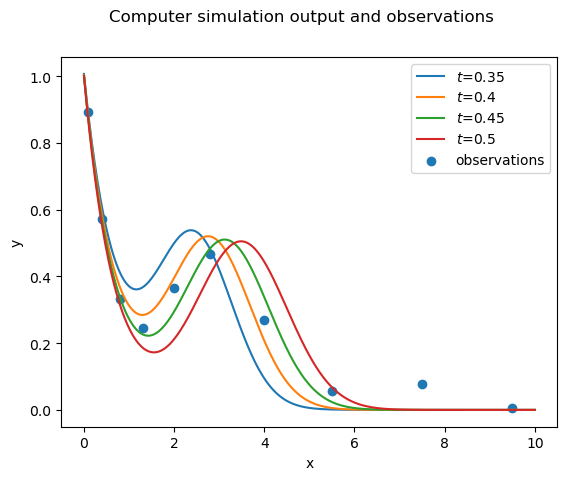

In [3]:
x = np.linspace(0, 10, 500)

thetas = [0.35, 0.4, 0.45, 0.5]

fig, ax = plt.subplots(nrows=1, ncols=1)
for theta in thetas:
    ax.plot(x, eta(x, theta), label=f"$t$={theta}")
ax.scatter(obs_x, obs_y, label="observations")
ax.legend()
fig.suptitle("Computer simulation output and observations")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

The Kennedy & O'Hagan (KOH) framework with the following definition is implemented in both setups.
\begin{equation*}
    z_i = \zeta(x_i) + e_i = \eta(x_i, \theta) + \delta(x_i) + e_i.
\end{equation*}
for $i=1,...,10$ where $z_i$ is the ith observation, $\zeta$ is the true process we model through $\eta$, $e_i$ is the observation noise for the ith observation and $\delta$ is the model discrepancy between the simulator and the true process.

The KOH framework models $\eta$ and $\delta$ as Gaussian processes. The MATLAB code uses seperate RBF kernels over the $x$ and $t$ variables for $\eta$ and uses a white noise kernel to model $\delta$. Consequently, `maltabmodel.py` implements the same model.

Both setups use the same prior distributions as given below ($p = q = 1$):
\begin{equation}
\begin{split}
    % \theta_k &\sim \text{Beta}(2,2) \text{ for } k=1,...,q \\
    \theta_k &\sim \text{Unif}(0,1) \text{ for } k=1,...,q \\
    \rho_{\eta, k} &\sim \text{Beta}(1,0.5) \text{ for } k=1,...,p+q \\
    \rho_{\delta, k} &\sim \text{Beta}(1,0.4) \text{ for } k=1,...,p \\
    \lambda_\eta &\sim \text{Gamma}(10,10) \\
    \lambda_\delta &\sim \text{Gamma}(10,0.3) \\
    % \lambda_e &\sim \text{Gamma}(10,0.03) \\
    \lambda_e &\sim \text{Gamma}(10,0.001) \\
    \lambda_{e,\eta} &\sim \text{Gamma}(10,0.001),
\end{split}
\end{equation}

## Parameterisations of the Kernel

The notation $X$ introduced below vertically stacks the locations of the field observations, $x_f$, and the locations of the computer outputs, $x_c$. It also includes the current estimate for $\theta$ stacked horizontally next to $x_f$ and the simulation values used for the simulation runs, $t$, are stacked horizontally next to $x_c$.

\begin{equation}
    X = \begin{pmatrix} x_f & \theta \\ x_c & t \end{pmatrix} \in \mathbb{R}^{(n+m) \times (p+q)}
\end{equation}

The MATLAB documentation uses an unusual parameterisation of the squared exponential function. The following demonstrates the covariance function used to model $\eta$, but the same function and parameterisation is used for modelling $\delta$.
\begin{equation}
    \Sigma_{\eta}[i,j] = \frac{1}{\lambda_{\eta}} \prod_{k=1}^{p+q} \rho_{\eta, k}^{4(X_{i,k} - X_{j,k})^2}.
\end{equation}
Bizarely, this is different from the actual implementation written in the MATLAB code...
\begin{equation}
    \Sigma_{\eta}[i,j] = \frac{1}{\lambda_{\eta}} \prod_{k=1}^{p+q} \exp \left\{ \beta_{\eta, k}{(X_{i,k} - X_{j,k})^2} \right\}.
\end{equation}
But this needs to compared against in the standard parameterisation used in GPJax:
\begin{equation}
    \Sigma_{\eta}[i,j] = \frac{1}{\lambda_{\eta}} \prod_{k=1}^{p+q} \exp \left\{ \frac{(X_{i,k} - X_{j,k})^2}{2\ell^2_{\eta, k}} \right\}.
\end{equation}
The covariance kernel for the discrepancy term is given by:
\begin{equation}
    \Sigma_{\delta}[i,j] = \frac{1}{\lambda_{\delta}}\delta_{i,j}
\end{equation}
where $\delta_{i,j} = 1$ if $i = j$ and $0$ otherwise is the Dirac delta function.

Converting between $\ell$, $\beta$ and $\rho$ is given by:
\begin{align}
    \rho &= e^{-\beta/4} & \rho &= e^{\frac{-1}{8\ell^2}} \\
    \beta &= -4\log(\rho) & \beta &= \frac{1}{2\ell^2} \\
    \ell &= \frac{1}{\sqrt{2\beta}} & \ell &= \sqrt{\frac{-1}{8\log(\rho)}} \\
\end{align}
These variables are subject to the following constraints: $0<\rho<1$, $\beta>0$ and $\ell>0$.

Notice that the priors are defined on the $\rho$ parameter. This means the variables must be converted from $\beta$ space in MATLAB and from $\ell$ space in GPJax to $\rho$ space when evaluating the priors.

# Load Data

## MATLAB

In [4]:
posterior_eta_predictions = np.loadtxt("data/matlab/posterior_eta_predictions.csv", delimiter=",", dtype=float)
xpred = posterior_eta_predictions[:,0]
E_etapred = posterior_eta_predictions[:,1]
C_etapred = posterior_eta_predictions[:,2:]
SD_etapred_diag = np.sqrt(np.diag(C_etapred))

posterior_y_predictions = np.loadtxt("data/matlab/posterior_y_predictions.csv", delimiter=",", dtype=float)
xpred = posterior_y_predictions[:,0]
E_ypred = posterior_y_predictions[:,1]
C_ypred = posterior_y_predictions[:,2:]
SD_ypred_diag = np.sqrt(np.diag(C_ypred))

E_biaspred = E_ypred - E_etapred
C_biaspred = C_ypred + C_etapred
SD_biaspred_diag = np.sqrt(np.diag(C_biaspred))

## KOH GPJax

In [5]:
import matlabmodel as mm
from dataloader import DataLoader
from mappings import map01toR, map0inftoR, beta2ell, mapRto01

# gpjax_parameters = {
#     "theta": map01toR(0.4255414963168313),
#     "rho_eta": map0inftoR(2.344494191164183e-06),
#     "rho_delta": map0inftoR(0.42845946133094337),
#     "lambda_eta": map0inftoR(0.2651089024663802),
#     "lambda_delta": map0inftoR(34.57040044854628),
#     "lambda_epsilon": map0inftoR(8998.670345608803),
#     "lambda_epsilon_eta": map0inftoR(78448.3715542844),
# }
parameters_from_mici = {
    "theta": -0.25819226917078575,
    "rho_eta_1": -2.3319931861014416,
    "rho_eta_2": -0.9566029331282767,
    "lambda_eta": -1.348872844210776,
    "lambda_delta": 3.5039660590819652,
    "lambda_epsilon": 9.048393559252899,
    "lambda_epsilon_eta": 11.263325443709089,
}
params = list(parameters_from_mici.values())

dataloader = DataLoader()
data = dataloader.get_data() # loads normalised/standardised data
gpjax_model = mm.MatlabModel(*data)
gpjax_posterior = gpjax_model.posterior(params)

xp_normalised = (xpred-np.min(xpred))/(np.max(xpred)-np.min(xpred))
theta_transformed = mapRto01(params[0]) # transform theta back to [0, 1]

gpjax_eta_pred = gpjax_posterior.predict_eta(
    np.vstack((xp_normalised, theta_transformed*np.ones_like(xp_normalised))).T,
    gpjax_model.dataset(params)
)
eta_pred_m = dataloader.inverse_transform_y(gpjax_eta_pred.mean()) # transform back to original scale
eta_pred_v = dataloader.inverse_transform_y_cov(gpjax_eta_pred.variance()) # transform back to original scale
eta_pred_sd = np.sqrt(eta_pred_v)

gpjax_obs_pred = gpjax_posterior.predict_obs(
    np.vstack((xp_normalised, theta_transformed*np.ones_like(xp_normalised))).T,
    gpjax_model.dataset(params)
)
obs_pred_m = dataloader.inverse_transform_y(gpjax_obs_pred.mean()) # transform back to original scale
obs_pred_v = dataloader.inverse_transform_y_cov(gpjax_obs_pred.variance()) # transform back to original scale
obs_pred_sd = np.sqrt(obs_pred_v)

bias_pred_m = obs_pred_m - eta_pred_m
bias_pred_v = obs_pred_v + eta_pred_v
bias_pred_sd = np.sqrt(bias_pred_v)

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


## Plot GP modelling simulator

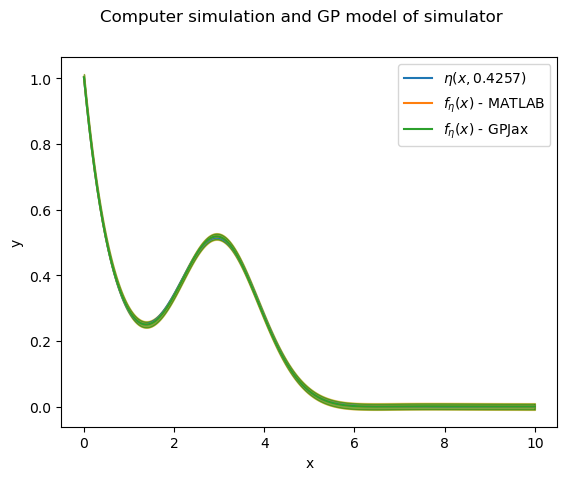

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(x, eta(x, 0.4257), label=r'$\eta(x, 0.4257)$')
ax.plot(xpred, E_etapred, label=r'$f_\eta(x)$ - MATLAB')
ax.fill_between(
    xpred, 
    E_etapred-1.96*SD_etapred_diag, 
    E_etapred+1.96*SD_etapred_diag, 
    alpha=0.5, 
    color='orange'
)
ax.plot(xpred, eta_pred_m, label=r'$f_\eta(x)$ - GPJax')
ax.fill_between(
    xpred, 
    eta_pred_m-1.96*eta_pred_sd, 
    eta_pred_m+1.96*eta_pred_sd, 
    alpha=0.5, 
    color='green'
)
# ax.scatter(obs_x, obs_y, label="observations")

ax.legend()
fig.suptitle("Computer simulation and GP model of simulator")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

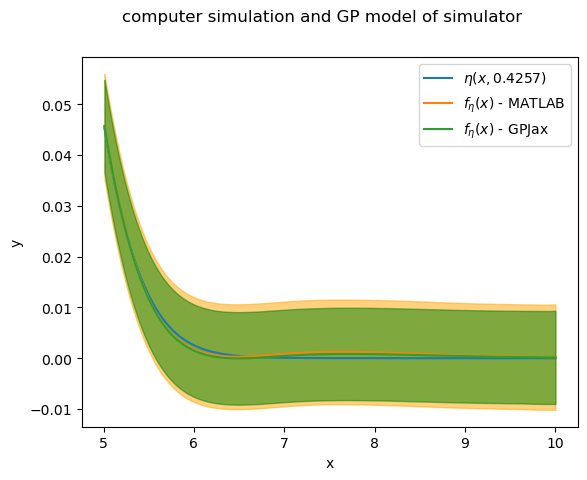

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1)
id_x = np.squeeze(np.argwhere(x>5))
id_xpred = np.squeeze(np.argwhere(xpred>5))

ax.plot(x[id_x], eta(x[id_x], 0.4257), label=r'$\eta(x, 0.4257)$')
ax.plot(xpred[id_xpred], E_etapred[id_xpred], label=r'$f_\eta(x)$ - MATLAB')
ax.fill_between(
    xpred[id_xpred], 
    E_etapred[id_xpred]-1.96*SD_etapred_diag[id_xpred], 
    E_etapred[id_xpred]+1.96*SD_etapred_diag[id_xpred], 
    alpha=0.5, 
    color='orange'
)
ax.plot(xpred[id_xpred], eta_pred_m[id_xpred], label=r'$f_\eta(x)$ - GPJax')
ax.fill_between(
    xpred[id_xpred], 
    eta_pred_m[id_xpred]-1.96*eta_pred_sd[id_xpred], 
    eta_pred_m[id_xpred]+1.96*eta_pred_sd[id_xpred], 
    alpha=0.5, 
    color='green'
)
# ax.scatter(obs_x, obs_y, label="observations")

ax.legend()
fig.suptitle("computer simulation and GP model of simulator")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Plot GP modelling true process

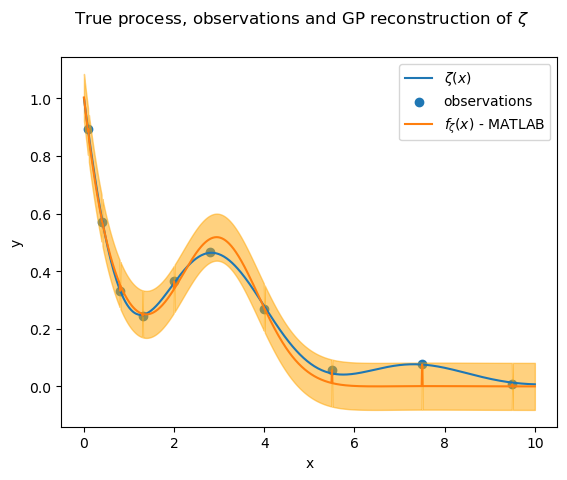

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(x, zeta(x), label=r'$\zeta(x)$')
ax.scatter(obs_x, obs_y, label="observations")
ax.plot(xpred, E_ypred, label=r'$f_\zeta(x)$ - MATLAB')
ax.fill_between(
    xpred, 
    E_ypred-1.96*SD_ypred_diag, 
    E_ypred+1.96*SD_ypred_diag, 
    alpha=0.5, 
    color='orange'
)
# ax.plot(xpred, obs_pred_m, label=r'$f_\zeta(x)$ - GPJax')
# ax.fill_between(
#     xpred, 
#     obs_pred_m-1.96*obs_pred_sd, 
#     obs_pred_m+1.96*obs_pred_sd, 
#     alpha=0.5, 
#     color='green'
# )
# ax.scatter(obs_x, obs_y, label="observations")

ax.legend()
fig.suptitle("True process, observations and GP reconstruction of $\zeta$")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

## Plot GP modelling bias

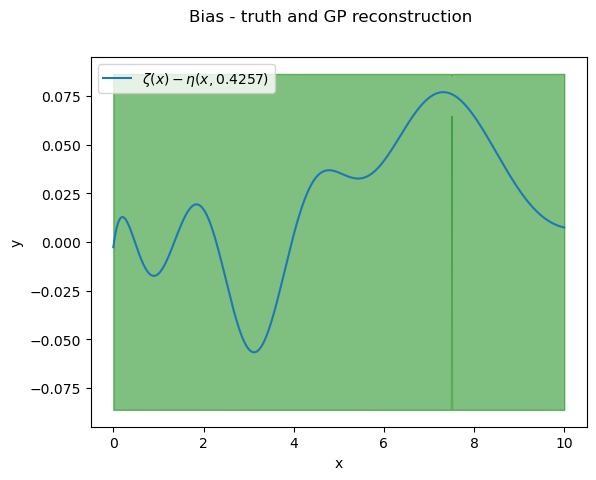

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(x, zeta(x)-eta(x,0.4257), label=r'$\zeta(x) - \eta(x,0.4257)$')
# ax.plot(xpred, E_biaspred, label=r'$f_\delta(x)$ - MATLAB')
# ax.fill_between(
#     xpred, 
#     E_biaspred-1.96*SD_biaspred_diag, 
#     E_biaspred+1.96*SD_biaspred_diag, 
#     alpha=0.5, 
#     color='orange'
# )
# ax.plot(xpred, bias_pred_m, label=r'$f_\delta(x)$ - GPJax')
ax.fill_between(
    xpred, 
    bias_pred_m-1.96*bias_pred_sd, 
    bias_pred_m+1.96*bias_pred_sd, 
    alpha=0.5, 
    color='green'
)
# ax.scatter(obs_x, obs_y, label="observations", color='orange')

ax.legend()
fig.suptitle("Bias - truth and GP reconstruction")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Build GP with MATLAB param values

In [10]:
parameters_from_matlab = {
    "theta": map01toR((0.4257-0.2)/(0.6-0.2)),
    "rho_eta": -2.3319931861014416,
    "rho_delta": -0.9566029331282767,
    "lambda_eta": -1.348872844210776,
    "lambda_delta": 3.5039660590819652,
    "lambda_epsilon": 9.048393559252899,
    "lambda_epsilon_eta": 11.263325443709089,
}
params_matlab = list(parameters_from_matlab.values())